# Lecture 29 – CSCI 3022


[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

## Implementing OLS in Code

Let's explore the Python syntax for performing ordinary least squares programmatically.

Today, we will work a dataset about hybrid cars.

In [2]:
hybrid = pd.read_csv('hybrid.csv')
hybrid.head()

vehicle  year      msrp  acceleration    mpg       class
0  Prius (1st Gen)  1997  24509.74          7.46  41.26     Compact
1             Tino  2000  35354.97          8.20  54.10     Compact
2  Prius (2nd Gen)  2000  26832.25          7.97  45.23     Compact
3          Insight  2000  18936.41          9.52  53.00  Two Seater
4  Civic (1st Gen)  2001  25833.38          7.04  47.04     Compact

We'll start by constructing a SLR model to predict the MSRP from the acceleration. Our model will take the form:

$$\text{MSRP} = \theta_0 + \theta_1 \text{acceleration}$$


<AxesSubplot:xlabel='acceleration', ylabel='msrp'>

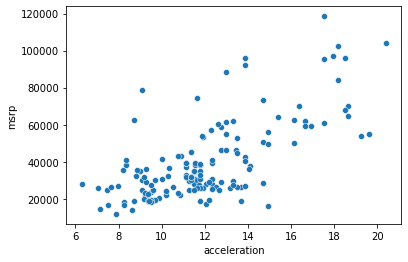

In [3]:
#Visualize this data:
sns.scatterplot(x=hybrid["acceleration"], y=hybrid["msrp"])

## Recall: SLR By Hand:
### Optimal Slope and Intercept for SLR


In lecture, we derived the following optimal parameters for the slope and intercept for the least squares regression model:

$$
\begin{align}
\text{slope} &= r * \frac{\text{Stdev}(y)}{\text{Stdev}(x)}\\
\text{intercept} & = \text{Mean}(y) - \text{slope} * \text{Mean}(x)
\end{align}
$$


Or, using the notation from lecture:


$$\large \hat{\theta}_1 = r \frac{\sigma_y}{\sigma_x}$$


$$\large \hat{\theta}_0 = \bar{y} - \hat{\theta}_1\bar{x}$$

and the prediction of the output of the $i^{th}$ datapoint, $\hat{y_i}$, will be:
$$\large \hat{y}_i = \hat{\theta}_0 + \hat{\theta}_1x_i$$

where $\bar{x}$, $\bar{y}$, $\sigma_x$, $\sigma_y$ correspond to the means and standard deviations of $x$ and $y$, respectively, and $r$ is the correlation coefficient.




In [4]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

In [5]:
def correlation(x, y):
    """Computes the correlation between arrays x and y"""
    x_su = standard_units(x)
    y_su = standard_units(y)
    return np.mean(x_su * y_su)

In [6]:
def slope(x, y):
    """Computes the slope of the regression line"""
    r = correlation(x, y)
    y_sd = np.std(y)
    x_sd = np.std(x)
    return r * y_sd / x_sd

In [7]:
def intercept(x, y):
    """Computes the intercept of the regression line"""
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return y_mean - slope(x, y)*x_mean

In [8]:
def fit_least_squares(x, y):
    return intercept(x,y), slope(x,y)

In [9]:
[intercept1, slope1] = fit_least_squares(hybrid["acceleration"],hybrid["msrp"])

print(r'MSRP = {0:.2f}(acc){1:.2f}'.format(slope1, intercept1))


MSRP = 5067.66(acc)-21282.17


In [10]:
def predict_linear(x, y):
    """Return an array of the regressions estimates at all the x values"""
    pred_y = slope(x, y) * x + intercept(x, y)
    return pred_y  

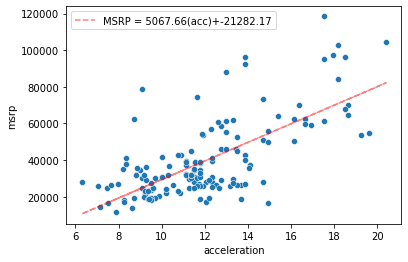

In [11]:
#Visualize the SLR:
sns.scatterplot(x=hybrid["acceleration"], y=hybrid["msrp"])
plt.plot(hybrid["acceleration"], 
         predict_linear(hybrid["acceleration"],hybrid["msrp"]),
         'r--',
         label =r'MSRP = {0:.2f}(acc)+{1:.2f}'.format(slope1, intercept1),
         alpha=0.5)
plt.legend()


### Analyze Model Fit
Next, we **plot the residuals.** 

When we make a residual plot, we'll put the residuals on the y-axis.  But we have an option of what to use for the x-axis:  either the single input feature (in this case `flipper_length` OR the fitted y-values (i.e. the predicted y output of the model).  When we have more than one feature i.e. in Multiple Linear Regression, we usually just plot the residuals vs the fitted y-values.  


For reference we'll provide both residual plots below.  We also replot the original dataset and our SLR model.



Text(0.5, 1.0, 'Residuals vs. predicted msrp')

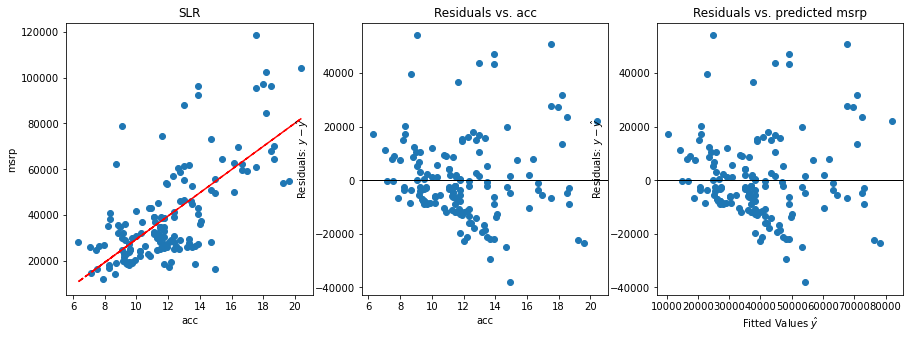

In [12]:
predicted_msrp = predict_linear(hybrid["acceleration"],hybrid["msrp"])

fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].scatter(hybrid["acceleration"], hybrid["msrp"])
ax[0].plot(hybrid["acceleration"], predicted_msrp, 'r--')
ax[0].set_xlabel('acc')
ax[0].set_ylabel('msrp')
ax[0].set_title('SLR')



ax[1].scatter(hybrid["acceleration"], hybrid["msrp"] - predicted_msrp)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'acc')
ax[1].set_ylabel(r'Residuals: $y - \hat{y}$');
ax[1].set_title("Residuals vs. acc")

ax[2].scatter(predicted_msrp, hybrid["msrp"] - predicted_msrp)
ax[2].axhline(0, c='black', linewidth=1)
ax[2].set_xlabel(r'Fitted Values $\hat{y}$')
ax[2].set_ylabel(r'Residuals: $y - \hat{y}$');
ax[2].set_title("Residuals vs. predicted msrp")



## Calculate RMSE:

In [13]:
def RMSE(y, pred_y):
    return np.sqrt(np.mean((y-pred_y)**2))

In [14]:
RMSE(hybrid["msrp"],predicted_msrp )

15339.646050991023

## SLR via `sklearn`

`sklearn` is a popular Python library for building and fitting models. In this lecture, we will walk through the general workflow for writing code for `sklearn`. While our examples will be focused on linear models, `sklearn` is highly adaptable for use on other (more complex) kinds of models. We'll see examples of this later in the semester. 

There are three steps to creating and using a model in `sklearn`. 

**(1) Initialize an instance of the model class**

`sklearn` stores "templates" of useful models for machine learning. We begin the modeling process by making a "copy" of one of these templates for our own use. Model initialization looks like `ModelClass()`, where `ModelClass` is the type of model we wish to create.

For now, let's create a linear regression model using `LinearRegression()`. 

`my_model` is now an instance of the `LinearRegression` class. You can think of it as the "idea" of a linear regression model. We haven't trained it yet, so it doesn't know any model parameters and cannot be used to make predictions. In fact, we haven't even told it what data to use for modeling! It simply waits for further instructions.

In [15]:
import sklearn.linear_model as lm

my_model = lm.LinearRegression()

my_model

LinearRegression()

**(2) Train the model using `.fit`**

Before the model can make predictions, we will need to fit it to our training data. When we fit the model, `sklearn` will run gradient descent behind the scenes to determine the optimal model parameters. It will then save these model parameters to our model instance for future use. 

All `sklearn` model classes include a `.fit` method. This function is used to fit the model. It takes in two inputs: the design matrix, `X`, and the target variable, `y`. 

Let's start by fitting a model with just one feature: the acceleration. We create a design matrix `X` by pulling out the `"acceleration"` column from the DataFrame. Notice that we use **double brackets** to extract this column. Why double brackets instead of just single brackets? The `.fit` method, by default, expects to receive **2-dimensional** data – some kind of data that includes both rows and columns. Writing `hybrid["acceleration"]` would return a 1D `Series`, causing `sklearn` to error. We avoid this by writing `hybrid[["acceleration"]]` to produce a 2D DataFrame. 

In [16]:
# .fit expects a 2D data design matrix, so we use double brackets to extract a DataFrame
X = hybrid[["acceleration"]]
y = hybrid["msrp"]

my_model.fit(X, y)

LinearRegression()

And in just three lines of code, our model has determined the optimal model parameters! Our single-feature model takes the form:

$$\text{MSRP} = \theta_0 + \theta_1 \text{acceleration}$$

Note that `LinearRegression` will automatically include an intercept term. (If you **don't** want to include an intercept you should use `lm.LinearRegression(fit_intercept=False)`)

The fitted model parameters are stored as attributes of the model instance. `my_model.intercept_` will return the value of $\hat{\theta}_0$ as a scalar. `my_model.coef_` will return all values $\hat{\theta}_1, 
\hat{\theta}_1, ...$ in an array. Because our model only contains one feature, we see just the value of $\hat{\theta}_1$ in the cell below.

In [17]:
# The intercept term, theta_0
my_model.intercept_

-21282.174068699125

In [18]:
# All parameters theta_1, ..., theta_p
my_model.coef_

array([5067.66110596])

**(3) Use the fitted model to make predictions**

Now that the model has been trained, we can use it to make predictions! To do so, we use the `.predict` method. `.predict` takes in one argument, the design matrix that should be used to generate predictions. To understand how the model performs on the training set, we would pass in the training data. Alternatively, to make predictions on unseen data, we would pass in a new dataset that wasn't used to train the model.

Below, we call `.predict` to generate model predictions on the original training data. As before, we use double brackets to ensure that we extract 2-dimensional data.

In [19]:
y_hat = my_model.predict(hybrid[["acceleration"]])

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat)**2))}")

The RMSE of the model is 15339.646050991027


## Multiple Linear Regression:  Adding More Features

What if we wanted a model with two features? 

$$\text{MSRP} = \theta_0 + \theta_1 \text{acceleration}+ \theta_2 \text{mpg}$$



In [20]:
px.scatter_3d(
    hybrid, 
    x="mpg", y="acceleration", z="msrp",
    hover_name="vehicle", 
    color="class", 
    height=800
)

We repeat this three-step process by intializing a new model object, then calling `.fit` and `.predict` as before.

In [21]:
# Step 1: initialize LinearRegression model
two_feature_model = lm.LinearRegression()

# Step 2: fit the model
X_two_features = hybrid[["acceleration", "mpg"]]
y = hybrid["msrp"]

two_feature_model.fit(X_two_features, y)




LinearRegression()

In [22]:
two_feature_model.intercept_

5796.5295277512705

In [23]:
two_feature_model.coef_

array([4176.43424819, -471.90152346])

In [24]:
# Step 3: make predictions
y_hat_two_features = two_feature_model.predict(X_two_features)

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat_two_features)**2))}")

The RMSE of the model is 14679.593508291922


## Scroll to the bottom of this notebook to visualize this model in 3D (this requires the datascience library)

### Analyze Residuals:

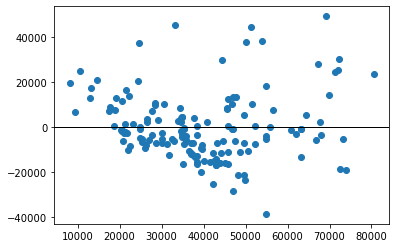

In [25]:

plt.scatter(two_feature_model.predict(X_two_features), hybrid["msrp"] - two_feature_model.predict(X_two_features))
plt.axhline(0, c='black', linewidth=1)


## Multiple $R^2$

Let's compute the coefficient of determination, or **multiple $R^2$**, for our model.

In [26]:
r2 = np.var(two_feature_model.predict(X_two_features)) / np.var(hybrid["msrp"])
r2

0.5272937905635546

Notice that this is better (i.e. closer to 1) than the r^2 for our SLR model:

In [27]:
little_r2 = correlation(hybrid["acceleration"],hybrid["msrp"])**2
little_r2

0.48382861453909676

## Fitting Non-linear Data

We could try to improve our predictions by defining a more complex equation:


$$\text{MSRP} = \theta_0 + \theta_1 \text{acceleration}+ \theta_2 \text{mpg}+ \theta_3({acceleration})^2 + \theta_4({mpg})^2$$





We repeat this three-step process by intializing a new model object, then calling `.fit` and `.predict` as before.

In [28]:
hybrid["acc_sq"] = hybrid["acceleration"]**2

In [29]:
hybrid["mpg_sq"] = hybrid["mpg"]**2

In [30]:
hybrid.head()

vehicle  year      msrp  acceleration    mpg       class   acc_sq  \
0  Prius (1st Gen)  1997  24509.74          7.46  41.26     Compact  55.6516   
1             Tino  2000  35354.97          8.20  54.10     Compact  67.2400   
2  Prius (2nd Gen)  2000  26832.25          7.97  45.23     Compact  63.5209   
3          Insight  2000  18936.41          9.52  53.00  Two Seater  90.6304   
4  Civic (1st Gen)  2001  25833.38          7.04  47.04     Compact  49.5616   

      mpg_sq  
0  1702.3876  
1  2926.8100  
2  2045.7529  
3  2809.0000  
4  2212.7616

In [31]:
# Step 1: initialize LinearRegression model
four_feature_model = lm.LinearRegression()

# Step 2: fit the model
X_four_features = hybrid[["acceleration", "mpg","acc_sq","mpg_sq"]]
y = hybrid["msrp"]

four_feature_model.fit(X_four_features, y)




LinearRegression()

In [32]:
four_feature_model.intercept_

115773.12877962453

In [33]:
four_feature_model.coef_

array([-5390.56588975, -3210.377882  ,   354.48548559,    34.56250485])

In [34]:
# Step 3: make predictions
y_hat_four_features = four_feature_model.predict(X_four_features)

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat_four_features)**2))}")

The RMSE of the model is 12930.67380839926


## Scroll to the bottom to visualize this 4 feature model

Text(0.5, 1.0, 'Residuals for Model with 4 features')

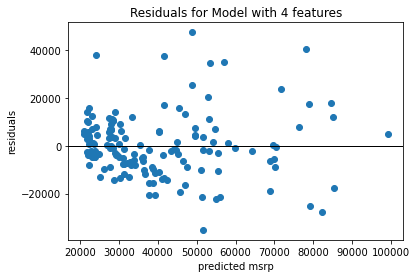

In [35]:
#Analyze Residuals:

plt.scatter(y_hat_four_features, y-y_hat_four_features)
plt.axhline(0, c='black', linewidth=1)
plt.xlabel("predicted msrp")
plt.ylabel("residuals")
plt.title("Residuals for Model with 4 features")


(9000.0, 101000.0)

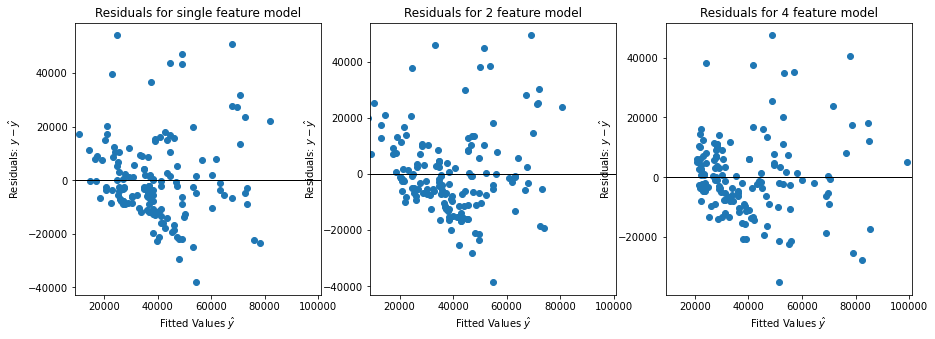

In [36]:
#Compare Residuals from our 3 models:

fig, ax = plt.subplots(1,3, figsize=(15, 5))


ax[0].scatter(predicted_msrp, hybrid["msrp"] - predicted_msrp)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Fitted Values $\hat{y}$')
ax[0].set_ylabel(r'Residuals: $y - \hat{y}$');
ax[0].set_title("Residuals for single feature model")
ax[0].set_xlim(9000,101000)


ax[1].scatter(two_feature_model.predict(X_two_features), hybrid["msrp"] - two_feature_model.predict(X_two_features))
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Fitted Values $\hat{y}$')
ax[1].set_ylabel(r'Residuals: $y - \hat{y}$');
ax[1].set_title("Residuals for 2 feature model")
ax[1].set_xlim(9000,101000)



ax[2].scatter(y_hat_four_features, hybrid["msrp"] - y_hat_four_features)
ax[2].axhline(0, c='black', linewidth=1)
ax[2].set_xlabel(r'Fitted Values $\hat{y}$')
ax[2].set_ylabel(r'Residuals: $y - \hat{y}$');
ax[2].set_title("Residuals for 4 feature model")
ax[2].set_xlim(9000,101000)



In [37]:
r2_v2 = np.var(y_hat_four_features) / np.var(hybrid["msrp"])
r2_v2

0.6332200725589334

## Feature Engineering

Feature engineering is the process of applying **feature functions** to generate new features for use in modeling. Below we will discuss

* Polynomial features

using a new dataset of vehicle information


In [38]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

mpg  cylinders  displacement    hp  weight  acceleration  model_year  \
19   26.0          4          97.0  46.0    1835          20.5          70   
102  26.0          4          97.0  46.0    1950          21.0          73   
326  43.4          4          90.0  48.0    2335          23.7          80   
325  44.3          4          90.0  48.0    2085          21.7          80   
244  43.1          4          90.0  48.0    1985          21.5          78   

     origin                             name  
19   europe     volkswagen 1131 deluxe sedan  
102  europe          volkswagen super beetle  
326  europe               vw dasher (diesel)  
325  europe             vw rabbit c (diesel)  
244  europe  volkswagen rabbit custom diesel

Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

MSE of model with (hp) feature: 23.9436629386031


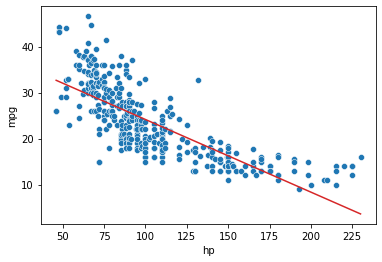

In [39]:
X = vehicles[["hp"]]
y = vehicles["mpg"]

hp_model = lm.LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"MSE of model with (hp) feature: {np.mean((y-hp_model_predictions)**2)}")

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

MSE of model with (hp^2) feature: 18.98476890761725


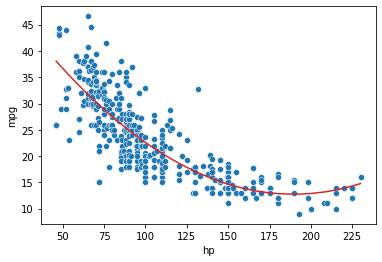

In [40]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = lm.LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"MSE of model with (hp^2) feature: {np.mean((y-hp2_model_predictions)**2)}")

What if we take things further and add even *more* polynomial features?

The cell below fits models of increasing complexity and computes their MSEs.

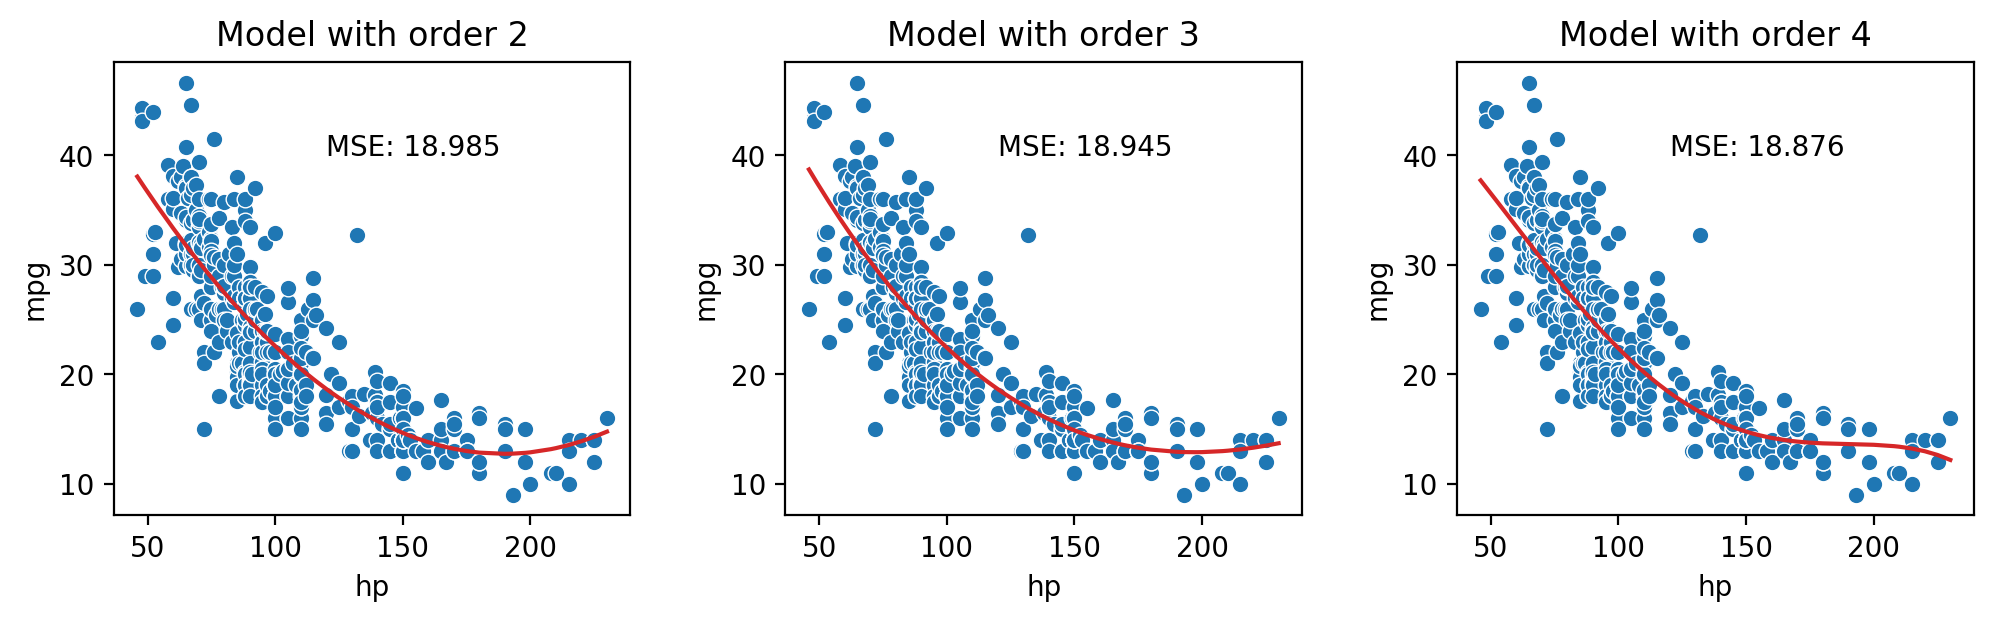

In [41]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = lm.LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = lm.LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"MSE: {np.round(mse(vehicles['mpg'], predictions_dict[i]), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

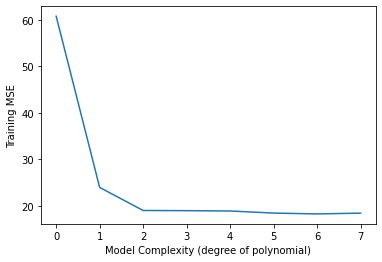

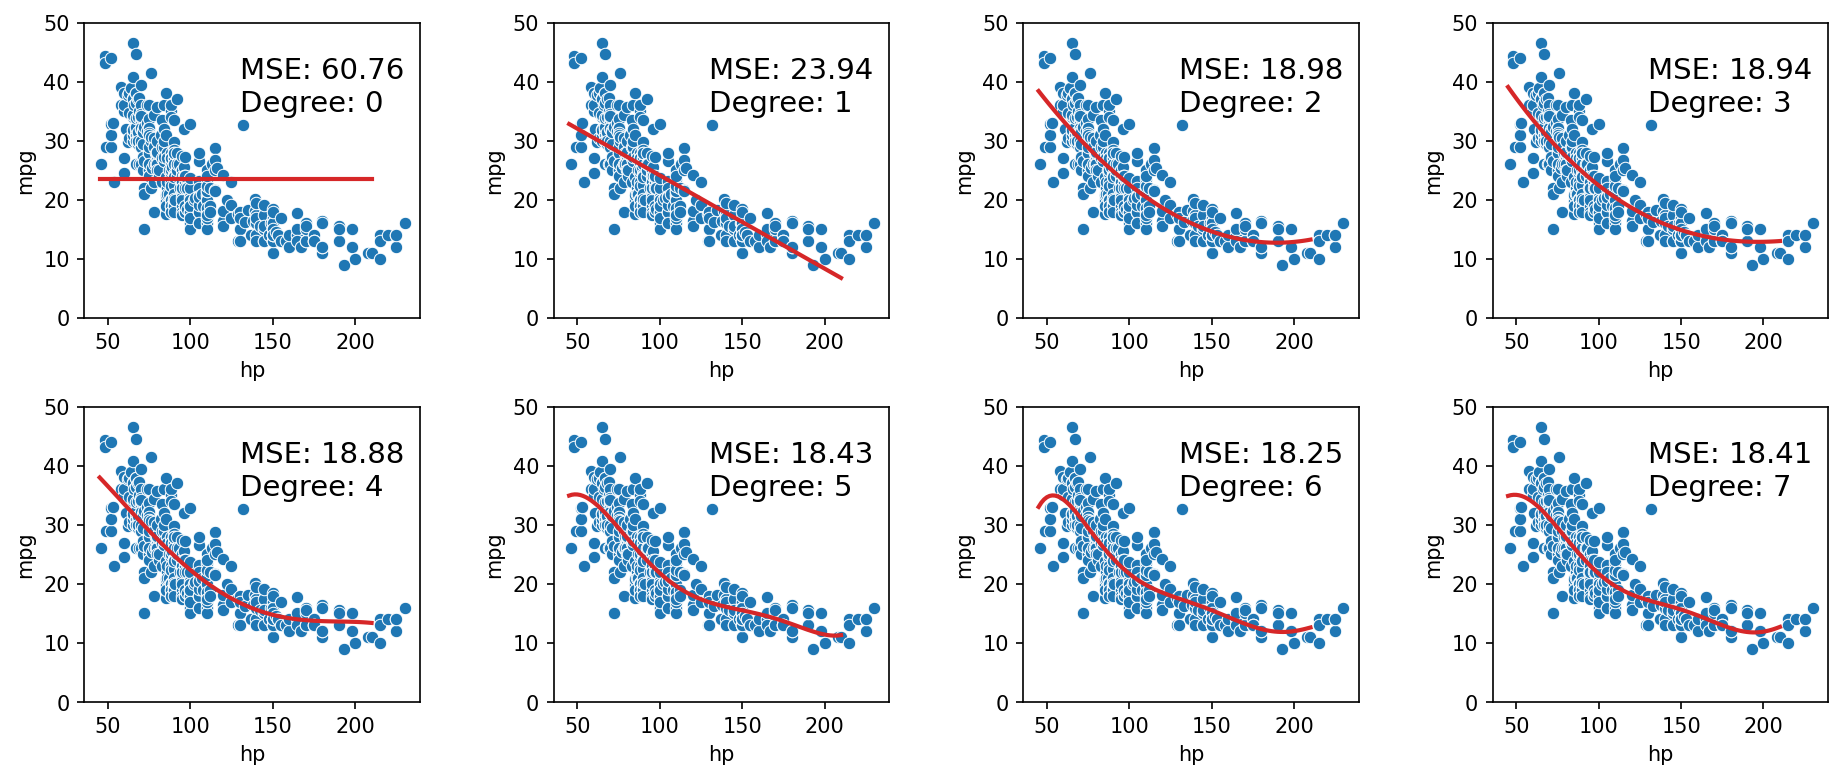

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]]))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 8)]
MSEs_and_k = pd.DataFrame({"k": range(0, 8), "MSE": errors})

plt.plot(range(0, 8), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");

def plot_degree_k_model(k, MSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', lm.LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 4
    col = k % 4
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"MSE: {MSEs_and_k.loc[k, 'MSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=4)

for k in range(8):
    plot_degree_k_model(k, MSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training MSE decreases, plateauing at roughly ~18.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points. For example, a set of 5 points can be perfectly modeled by a degree 4 model.

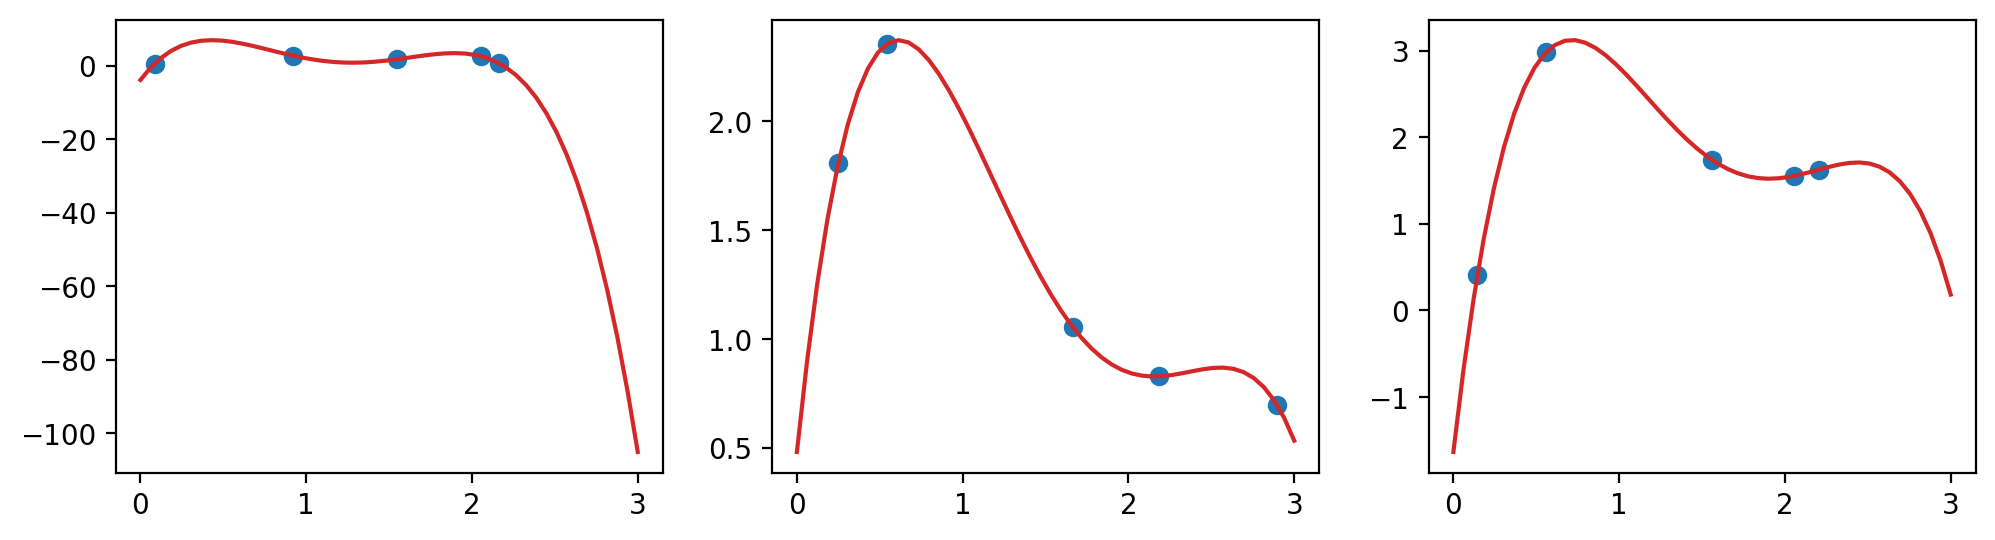

In [43]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 

Suppose we obtain a random sample of 6 datapoints from our population of vehicle data. We want to train a model on these 6 points and use it to make predictions on unseen data (perhaps cars for which we don't already know the true `mpg`). 

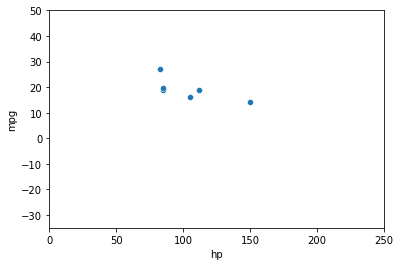

In [44]:
np.random.seed(100)

sample_6 = vehicles.sample(6)

sns.scatterplot(data=sample_6, x="hp", y="mpg")
plt.ylim(-35, 50)
plt.xlim(0, 250);

If we design a model with polynomial degree 5, we can make perfect predictions on this sample of training data.

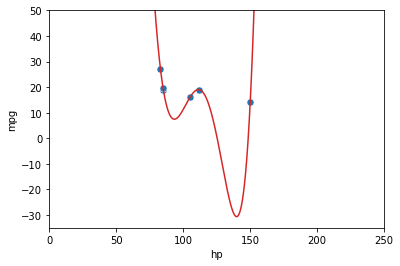

In [45]:
degree_5_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

degree_5_model.fit(sample_6[["hp"]], sample_6["mpg"])
xs = np.linspace(0, 250, 1000)
degree_5_model_predictions = degree_5_model.predict(xs[:, np.newaxis])

plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=sample_6, x="hp", y="mpg", s=50)
plt.ylim(-35, 50)
plt.xlim(0, 250);

However, when we reapply this fitted model to the full population of data, it fails to capture the major trends of the dataset.

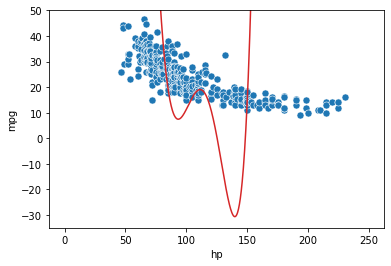

In [46]:
plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=vehicles, x="hp", y="mpg", s=50)
plt.ylim(-35, 50);

The model has **overfit** to the data used to train it. It has essentially "memorized" the six datapoints used during model fitting, and does not generalize well to new data. 

Complex models tend to be more sensitive to the data used to train them. The **variance** of a model refers to its tendency to vary depending on the training data used during model fitting. It turns out that our degree-5 model has very high model variance. If we randomly sample new sets of datapoints to use in training, the model varies erratically. 

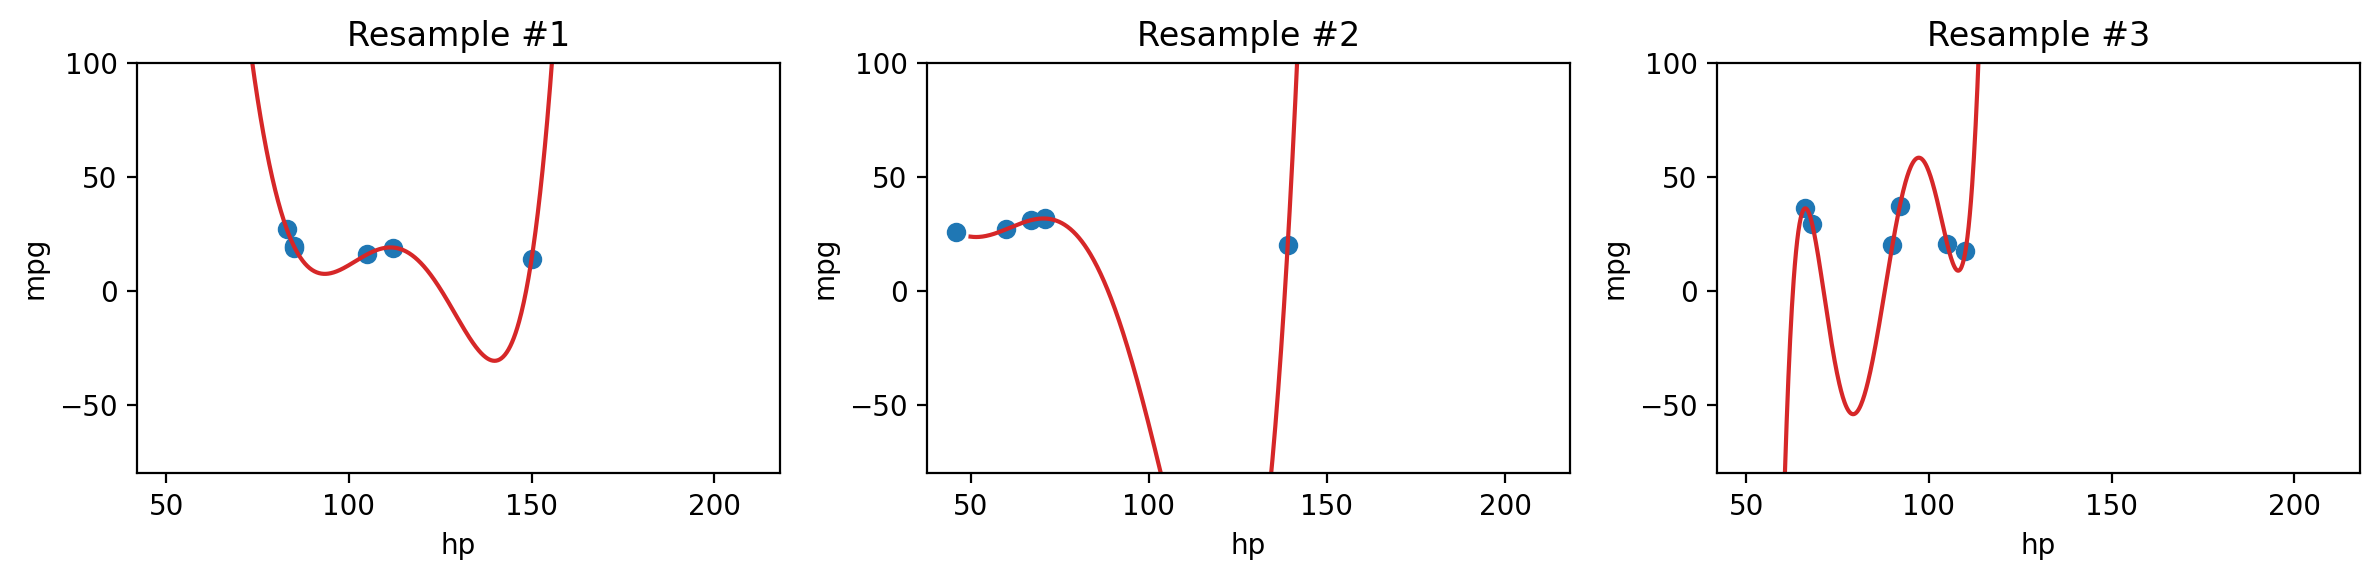

In [47]:
np.random.seed(100)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    sample = vehicles.sample(6)

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    ax[i].scatter(sample[["hp"]], sample["mpg"])

    xs = np.linspace(50, 210, 1000)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red")
    ax[i].set_ylim(-80, 100)
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].set_title(f"Resample #{i+1}")
    
fig.tight_layout();

## Visualization of 2 feature model (acc and mpg):

In [48]:
from datascience import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [49]:

a=two_feature_model.coef_[0]
b=two_feature_model.coef_[1]
c=two_feature_model.intercept_

mpg_range = np.arange(10, 80)
acceleration_range = np.arange(5, 25)
predictions = Table(["mpg", "acc", "pred"])
for mpg in mpg_range:
    for acc in acceleration_range: 
        pred = a * acc + b * mpg + c
        predictions.append([mpg, acc, pred])



fig = px.scatter_3d(
    hybrid, 
    x="mpg", y="acceleration", z="msrp",
    hover_name="vehicle", 
    color="class", 
    height=800
)
fig.add_surface(
    x = mpg_range, y = acceleration_range,
    z = predictions.column("pred").reshape(len(mpg_range), len(acceleration_range)).T,
    showscale=False
)

## Visualization of 4 feature model (acc, mpg, acc^2 and mpg^2):

In [50]:
a=four_feature_model.coef_[0]
b=four_feature_model.coef_[1]
c=four_feature_model.coef_[2]
d=four_feature_model.coef_[3]
e=four_feature_model.intercept_


mpg_range = np.arange(10, 80)
acceleration_range = np.arange(5, 25)
predictions = Table(["mpg", "acc", "pred"])
for mpg in mpg_range:
    for acc in acceleration_range: 
        pred = a*acc + b*mpg + c*acc**2 + d*mpg**2 + e
        predictions.append([mpg, acc, pred])
        
fig = px.scatter_3d(
    hybrid, 
    x="mpg", y="acceleration", z="msrp",
    hover_name="vehicle", 
    color="class", 
    height=800
)
fig.add_surface(
    x = mpg_range, y = acceleration_range,
    z = predictions.column("pred").reshape(len(mpg_range), len(acceleration_range)).T,
    showscale=False
)